In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/"
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['test', 'valid', 'models', 'train', 'tmp']

In [7]:
os.listdir(f'{PATH}valid')

['.DS_Store', 'kali', 'ringo']

In [8]:
files = os.listdir(f'{PATH}valid/ringo')[:5]
files

['r00254.jpg', 'r00478.jpg', 'r00470.jpg', 'r00307.jpg', 'r00089.jpg']

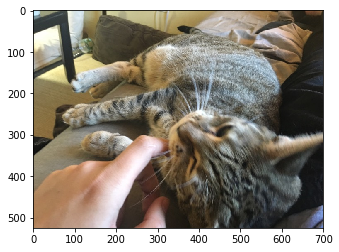

In [9]:
img = plt.imread(f'{PATH}valid/ringo/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(525, 700, 3)

In [11]:
img[:4,:4]

array([[[196, 233, 251],
        [196, 233, 249],
        [198, 234, 250],
        [198, 234, 248]],

       [[196, 233, 251],
        [196, 233, 249],
        [198, 234, 248],
        [198, 234, 248]],

       [[196, 232, 248],
        [197, 233, 249],
        [197, 233, 247],
        [197, 233, 247]],

       [[196, 232, 248],
        [196, 232, 248],
        [197, 233, 247],
        [197, 233, 247]]], dtype=uint8)

In [12]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.607748   0.363452   0.821256  
    1      0.455352   0.35204    0.845411                 



[array([ 0.35204]), 0.8454106288831591]

In [13]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [14]:
data.classes

['kali', 'ringo']

In [15]:
log_preds = learn.predict()
log_preds.shape

(207, 2)

In [16]:
log_preds[:10]

array([[-0.09116, -2.44034],
       [-0.08071, -2.55702],
       [-0.03227, -3.44969],
       [-0.08613, -2.49463],
       [-0.09477, -2.40327],
       [-0.17707, -1.81846],
       [-0.06243, -2.80478],
       [-0.00006, -9.71889],
       [-0.25003, -1.50859],
       [-0.01948, -3.94793]], dtype=float32)

In [17]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])     

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


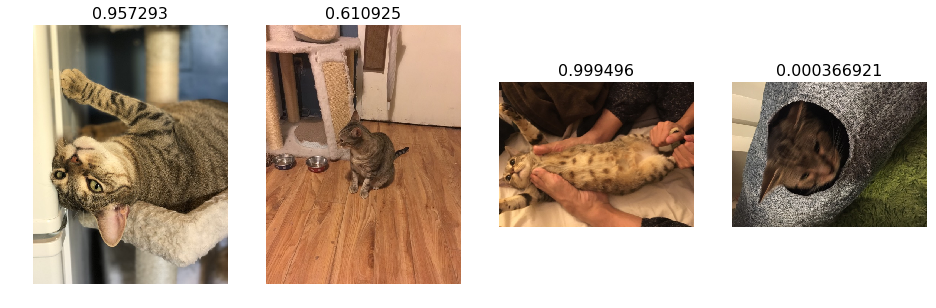

In [19]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


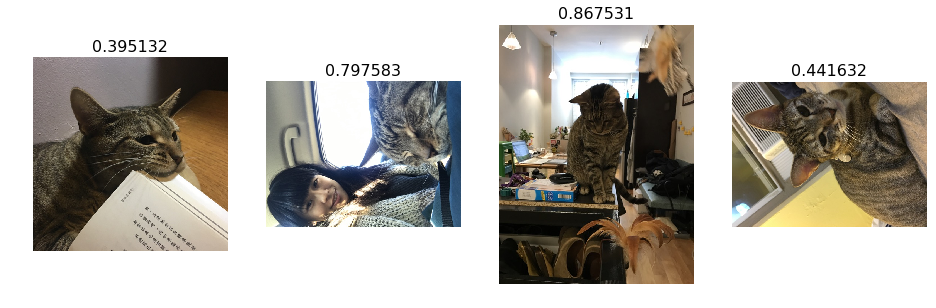

In [20]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [21]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct kali


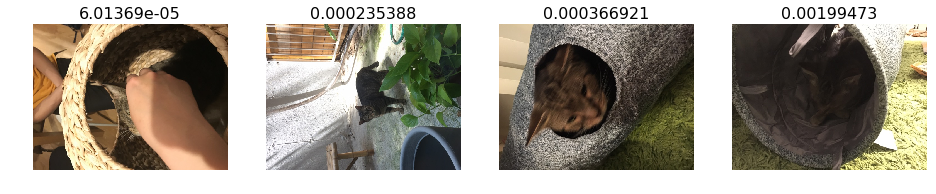

In [22]:
plot_val_with_title(most_by_correct(0, True), "Most correct kali")

Most correct ringo


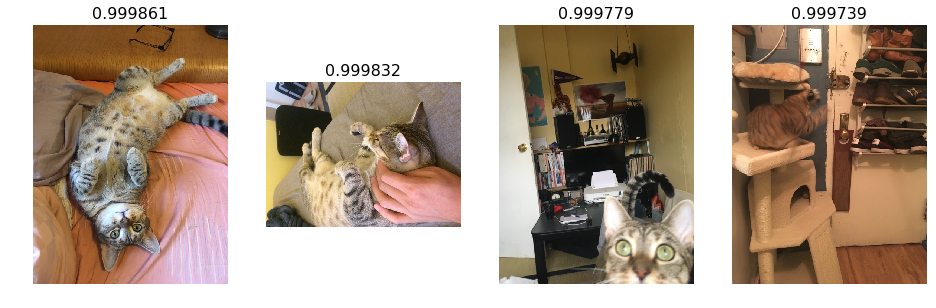

In [23]:
plot_val_with_title(most_by_correct(1, True), "Most correct ringo")

Most incorrect kali


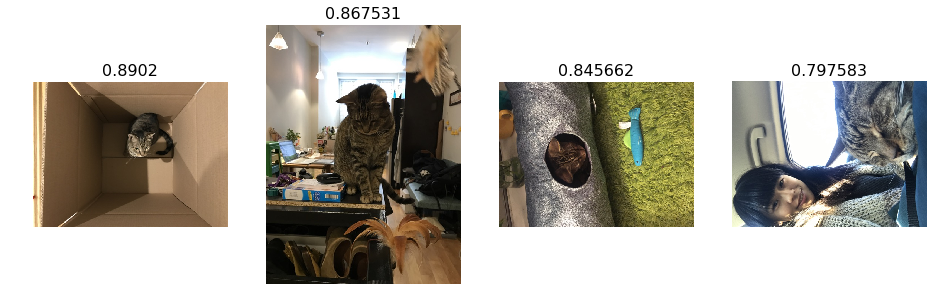

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect kali")

Most incorrect ringo


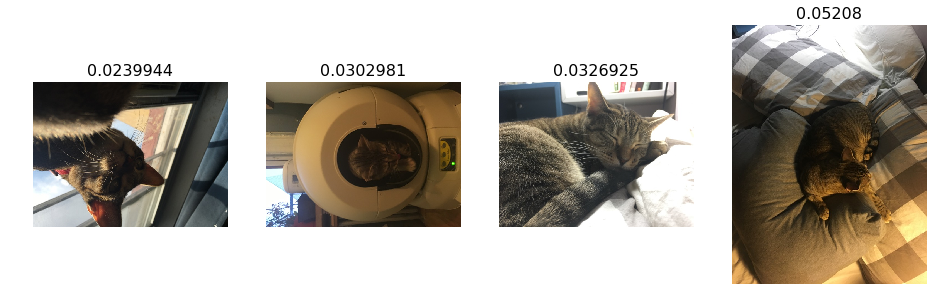

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect ringo")

Most uncertain predictions


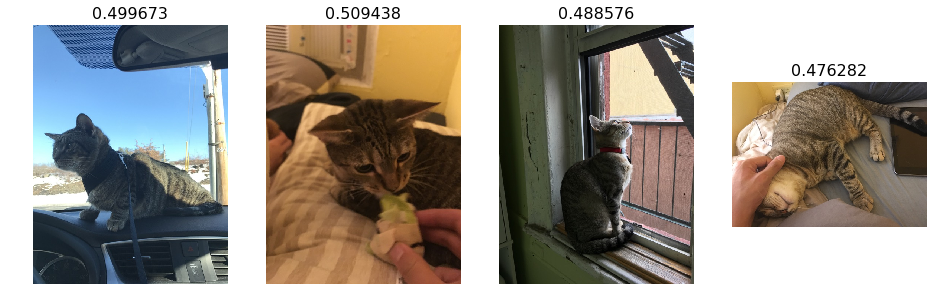

In [26]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")